In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [6]:
X_all = []
Y_all = []

image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112)) 
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [7]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [8]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [28]:
## vary the #of filters in each conv layer
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Choice("Conv1", values=[120,128,256,512]) ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)


        c2 = Convolution2D(filters=hp.Choice("Conv2", values=[120,128,256,512]),kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)

        c2 = Convolution2D(filters=hp.Choice("Conv3", values=[120,128,256,512]),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=hp.Choice("Conv4", values=[120,128,256,512]),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(512)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(256)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(128)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [29]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [30]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.6059 - acc: 0.4977 - val_loss: 1.6000 - val_acc: 0.5372
Epoch 2/70
2172/2172 - 3s - loss: 1.3027 - acc: 0.5589 - val_loss: 2.4220 - val_acc: 0.3595
Epoch 3/70
2172/2172 - 3s - loss: 1.1841 - acc: 0.5944 - val_loss: 1.0426 - val_acc: 0.6446
Epoch 4/70
2172/2172 - 3s - loss: 1.1642 - acc: 0.5930 - val_loss: 1.2511 - val_acc: 0.5207
Epoch 5/70
2172/2172 - 3s - loss: 1.1036 - acc: 0.6160 - val_loss: 1.0891 - val_acc: 0.6488
Epoch 6/70
2172/2172 - 3s - loss: 1.0450 - acc: 0.6266 - val_loss: 0.8386 - val_acc: 0.6694
Epoch 7/70
2172/2172 - 3s - loss: 0.9978 - acc: 0.6390 - val_loss: 0.8997 - val_acc: 0.7149
Epoch 8/70
2172/2172 - 3s - loss: 0.9174 - acc: 0.6814 - val_loss: 2.4399 - val_acc: 0.2727
Epoch 9/70
2172/2172 - 3s - loss: 0.8850 - acc: 0.6823 - val_loss: 1.2269 - val_acc: 0.5661
Epoch 10/70
2172/2172 - 3s - loss: 0.8158 - acc: 0.7210 - val_loss: 1.9070 - val_acc: 0.4917
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.5826 - acc: 0.8034 - val_loss: 0.5830 - val_acc: 0.8347
Epoch 20/70
2172/2172 - 3s - loss: 0.5280 - acc: 0.8246 - val_loss: 0.7647 - val_acc: 0.7686
Epoch 21/70
2172/2172 - 3s - loss: 0.5237 - acc: 0.8232 - val_loss: 1.3562 - val_acc: 0.5992
Epoch 22/70
2172/2172 - 3s - loss: 0.4999 - acc: 0.8430 - val_loss: 0.4187 - val_acc: 0.8636
Epoch 23/70
2172/2172 - 3s - loss: 0.5115 - acc: 0.8361 - val_loss: 0.5747 - val_acc: 0.8017
Epoch 24/70
2172/2172 - 3s - loss: 0.4535 - acc: 0.8485 - val_loss: 0.5520 - val_acc: 0.8347
Epoch 25/70
2172/2172 - 3s - loss: 0.4657 - acc: 0.8471 - val_loss: 0.8583 - val_acc: 0.6736
Epoch 26/70
2172/2172 - 3s - loss: 0.4442 - acc: 0.8508 - val_loss: 0.5039 - val_acc: 0.8471
Epoch 27/70
2172/2172 - 3s - loss: 0.4170 - acc: 0.8568 - val_loss: 0.4597 - val_acc: 0.8554
Epoch 28/70
2172/2172 - 3s - loss: 0.4178 - acc: 0.8642 - val_loss: 0.4200 - val_acc: 0.8554
Epoch 29/70
2172/2172 - 3s - loss: 0.3843 - acc: 0.8748 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.5790 - acc: 0.4995 - val_loss: 1.4754 - val_acc: 0.5950
Epoch 2/70
2172/2172 - 5s - loss: 1.3236 - acc: 0.5677 - val_loss: 1.2020 - val_acc: 0.6364
Epoch 3/70
2172/2172 - 5s - loss: 1.2117 - acc: 0.5783 - val_loss: 1.2930 - val_acc: 0.5207
Epoch 4/70
2172/2172 - 5s - loss: 1.1407 - acc: 0.6013 - val_loss: 1.1710 - val_acc: 0.5413
Epoch 5/70
2172/2172 - 5s - loss: 1.1104 - acc: 0.6091 - val_loss: 0.9621 - val_acc: 0.6570
Epoch 6/70
2172/2172 - 5s - loss: 1.0659 - acc: 0.6174 - val_loss: 1.2980 - val_acc: 0.5744
Epoch 7/70
2172/2172 - 5s - loss: 1.0261 - acc: 0.6354 - val_loss: 1.0305 - val_acc: 0.6529
Epoch 8/70
2172/2172 - 5s - loss: 0.9840 - acc: 0.6464 - val_loss: 0.9786 - val_acc: 0.6818
Epoch 9/70
2172/2172 - 4s - loss: 0.9000 - acc: 0.6883 - val_loss: 0.9351 - val_acc: 0.6942
Epoch 10/70
2172/2172 - 5s - loss: 0.8467 - acc: 0.7099 - val_loss: 0.8070 - val_acc: 0.7149
Epoch 11/70
2172/2172 - 5s - los

Epoch 19/70
2172/2172 - 5s - loss: 0.5458 - acc: 0.8273 - val_loss: 1.7975 - val_acc: 0.4917
Epoch 20/70
2172/2172 - 5s - loss: 0.5223 - acc: 0.8297 - val_loss: 1.2726 - val_acc: 0.6157
Epoch 21/70
2172/2172 - 5s - loss: 0.5086 - acc: 0.8343 - val_loss: 0.6527 - val_acc: 0.7934
Epoch 22/70
2172/2172 - 5s - loss: 0.4818 - acc: 0.8402 - val_loss: 0.3815 - val_acc: 0.8843
Epoch 23/70
2172/2172 - 5s - loss: 0.4763 - acc: 0.8407 - val_loss: 0.5858 - val_acc: 0.8264
Epoch 24/70
2172/2172 - 5s - loss: 0.4435 - acc: 0.8564 - val_loss: 0.3477 - val_acc: 0.8512
Epoch 25/70
2172/2172 - 5s - loss: 0.4516 - acc: 0.8504 - val_loss: 3.5140 - val_acc: 0.5826
Epoch 26/70
2172/2172 - 5s - loss: 0.4463 - acc: 0.8564 - val_loss: 0.4080 - val_acc: 0.8760
Epoch 27/70
2172/2172 - 5s - loss: 0.4128 - acc: 0.8679 - val_loss: 0.9712 - val_acc: 0.6736
Epoch 28/70
2172/2172 - 5s - loss: 0.4194 - acc: 0.8564 - val_loss: 0.4323 - val_acc: 0.8471
Epoch 29/70
2172/2172 - 5s - loss: 0.4021 - acc: 0.8711 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 8s - loss: 1.6109 - acc: 0.5037 - val_loss: 1.5062 - val_acc: 0.5455
Epoch 2/70
2172/2172 - 7s - loss: 1.3765 - acc: 0.5534 - val_loss: 1.1353 - val_acc: 0.6364
Epoch 3/70
2172/2172 - 7s - loss: 1.2002 - acc: 0.5939 - val_loss: 1.0301 - val_acc: 0.6488
Epoch 4/70
2172/2172 - 7s - loss: 1.1664 - acc: 0.6004 - val_loss: 1.1026 - val_acc: 0.6116
Epoch 5/70
2172/2172 - 7s - loss: 1.1188 - acc: 0.6133 - val_loss: 1.1761 - val_acc: 0.6198
Epoch 6/70
2172/2172 - 7s - loss: 1.0826 - acc: 0.6285 - val_loss: 1.2136 - val_acc: 0.4752
Epoch 7/70
2172/2172 - 7s - loss: 1.0134 - acc: 0.6436 - val_loss: 1.0274 - val_acc: 0.6612
Epoch 8/70
2172/2172 - 7s - loss: 0.9717 - acc: 0.6501 - val_loss: 1.5413 - val_acc: 0.3182
Epoch 9/70
2172/2172 - 7s - loss: 0.8908 - acc: 0.6878 - val_loss: 1.9673 - val_acc: 0.2686
Epoch 10/70
2172/2172 - 7s - loss: 0.8526 - acc: 0.7122 - val_loss: 3.2550 - val_acc: 0.1860
Epoch 11/70
2172/2172 - 7s - los

Epoch 19/70
2172/2172 - 7s - loss: 0.5478 - acc: 0.8181 - val_loss: 0.7764 - val_acc: 0.8182
Epoch 20/70
2172/2172 - 7s - loss: 0.5068 - acc: 0.8227 - val_loss: 0.8619 - val_acc: 0.6446
Epoch 21/70
2172/2172 - 7s - loss: 0.5205 - acc: 0.8273 - val_loss: 0.4657 - val_acc: 0.8595
Epoch 22/70
2172/2172 - 7s - loss: 0.4877 - acc: 0.8439 - val_loss: 0.3811 - val_acc: 0.8636
Epoch 23/70
2172/2172 - 7s - loss: 0.4723 - acc: 0.8435 - val_loss: 0.5999 - val_acc: 0.7975
Epoch 24/70
2172/2172 - 7s - loss: 0.4243 - acc: 0.8517 - val_loss: 0.4393 - val_acc: 0.8223
Epoch 25/70
2172/2172 - 7s - loss: 0.5050 - acc: 0.8425 - val_loss: 0.8461 - val_acc: 0.6818
Epoch 26/70
2172/2172 - 7s - loss: 0.4020 - acc: 0.8651 - val_loss: 0.2871 - val_acc: 0.8884
Epoch 27/70
2172/2172 - 7s - loss: 0.4422 - acc: 0.8577 - val_loss: 2.4567 - val_acc: 0.2727
Epoch 28/70
2172/2172 - 7s - loss: 0.3981 - acc: 0.8725 - val_loss: 0.3872 - val_acc: 0.8512
Epoch 29/70
2172/2172 - 7s - loss: 0.4021 - acc: 0.8720 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.5853 - acc: 0.5078 - val_loss: 1.4614 - val_acc: 0.6074
Epoch 2/70
2172/2172 - 4s - loss: 1.3375 - acc: 0.5654 - val_loss: 1.3696 - val_acc: 0.5579
Epoch 3/70
2172/2172 - 4s - loss: 1.2078 - acc: 0.5856 - val_loss: 1.6772 - val_acc: 0.5744
Epoch 4/70
2172/2172 - 4s - loss: 1.1630 - acc: 0.6091 - val_loss: 1.3453 - val_acc: 0.5455
Epoch 5/70
2172/2172 - 4s - loss: 1.1208 - acc: 0.6110 - val_loss: 0.9694 - val_acc: 0.6653
Epoch 6/70
2172/2172 - 5s - loss: 1.0793 - acc: 0.6183 - val_loss: 0.9866 - val_acc: 0.6736
Epoch 7/70
2172/2172 - 4s - loss: 1.0665 - acc: 0.6192 - val_loss: 1.1038 - val_acc: 0.6364
Epoch 8/70
2172/2172 - 4s - loss: 0.9540 - acc: 0.6607 - val_loss: 1.7428 - val_acc: 0.2810
Epoch 9/70
2172/2172 - 4s - loss: 0.9302 - acc: 0.6855 - val_loss: 1.7233 - val_acc: 0.6281
Epoch 10/70
2172/2172 - 4s - loss: 0.8523 - acc: 0.7076 - val_loss: 0.6972 - val_acc: 0.7851
Epoch 11/70
2172/2172 - 4s - los

Epoch 19/70
2172/2172 - 4s - loss: 0.5528 - acc: 0.8112 - val_loss: 0.6173 - val_acc: 0.8017
Epoch 20/70
2172/2172 - 5s - loss: 0.5354 - acc: 0.8227 - val_loss: 0.6714 - val_acc: 0.7645
Epoch 21/70
2172/2172 - 5s - loss: 0.4995 - acc: 0.8241 - val_loss: 1.0627 - val_acc: 0.6736
Epoch 22/70
2172/2172 - 5s - loss: 0.5669 - acc: 0.8158 - val_loss: 0.8673 - val_acc: 0.7025
Epoch 23/70
2172/2172 - 5s - loss: 0.5050 - acc: 0.8306 - val_loss: 0.4334 - val_acc: 0.8471
Epoch 24/70
2172/2172 - 5s - loss: 0.4774 - acc: 0.8402 - val_loss: 0.6008 - val_acc: 0.7934
Epoch 25/70
2172/2172 - 5s - loss: 0.4592 - acc: 0.8568 - val_loss: 0.5299 - val_acc: 0.8140
Epoch 26/70
2172/2172 - 4s - loss: 0.4574 - acc: 0.8605 - val_loss: 0.9943 - val_acc: 0.6488
Epoch 27/70
2172/2172 - 5s - loss: 0.4168 - acc: 0.8656 - val_loss: 0.3313 - val_acc: 0.8967
Epoch 28/70
2172/2172 - 5s - loss: 0.3967 - acc: 0.8775 - val_loss: 0.2849 - val_acc: 0.9091
Epoch 29/70
2172/2172 - 5s - loss: 0.3723 - acc: 0.8798 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 7s - loss: 1.5305 - acc: 0.5175 - val_loss: 1.5627 - val_acc: 0.3967
Epoch 2/70
2172/2172 - 7s - loss: 1.3151 - acc: 0.5677 - val_loss: 1.3514 - val_acc: 0.6157
Epoch 3/70
2172/2172 - 6s - loss: 1.1817 - acc: 0.5967 - val_loss: 1.9575 - val_acc: 0.5744
Epoch 4/70
2172/2172 - 6s - loss: 1.1077 - acc: 0.6050 - val_loss: 1.1851 - val_acc: 0.5909
Epoch 5/70
2172/2172 - 7s - loss: 1.0736 - acc: 0.6206 - val_loss: 1.2453 - val_acc: 0.6033
Epoch 6/70
2172/2172 - 7s - loss: 1.0583 - acc: 0.6229 - val_loss: 1.3088 - val_acc: 0.6116
Epoch 7/70
2172/2172 - 7s - loss: 1.0085 - acc: 0.6367 - val_loss: 0.8294 - val_acc: 0.6901
Epoch 8/70
2172/2172 - 7s - loss: 0.9416 - acc: 0.6602 - val_loss: 0.9215 - val_acc: 0.6612
Epoch 9/70
2172/2172 - 7s - loss: 0.9147 - acc: 0.6888 - val_loss: 0.8327 - val_acc: 0.7025
Epoch 10/70
2172/2172 - 6s - loss: 0.8432 - acc: 0.7187 - val_loss: 1.9602 - val_acc: 0.3017
Epoch 11/70
2172/2172 - 7s - los

Epoch 19/70
2172/2172 - 7s - loss: 0.5884 - acc: 0.8052 - val_loss: 0.5374 - val_acc: 0.8306
Epoch 20/70
2172/2172 - 7s - loss: 0.5257 - acc: 0.8237 - val_loss: 0.7763 - val_acc: 0.7397
Epoch 21/70
2172/2172 - 7s - loss: 0.5287 - acc: 0.8214 - val_loss: 0.5509 - val_acc: 0.8223
Epoch 22/70
2172/2172 - 7s - loss: 0.5379 - acc: 0.8246 - val_loss: 0.5363 - val_acc: 0.7934
Epoch 23/70
2172/2172 - 7s - loss: 0.4702 - acc: 0.8439 - val_loss: 0.5582 - val_acc: 0.8017
Epoch 24/70
2172/2172 - 7s - loss: 0.4855 - acc: 0.8462 - val_loss: 0.6399 - val_acc: 0.7851
Epoch 25/70
2172/2172 - 7s - loss: 0.4479 - acc: 0.8476 - val_loss: 0.5055 - val_acc: 0.8306
Epoch 26/70
2172/2172 - 7s - loss: 0.4844 - acc: 0.8439 - val_loss: 1.2818 - val_acc: 0.5868
Epoch 27/70
2172/2172 - 6s - loss: 0.4617 - acc: 0.8471 - val_loss: 0.6571 - val_acc: 0.7438
Epoch 28/70
2172/2172 - 7s - loss: 0.4290 - acc: 0.8587 - val_loss: 0.3241 - val_acc: 0.8926
Epoch 29/70
2172/2172 - 7s - loss: 0.4242 - acc: 0.8596 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [38]:
tuner.results_summary()

In [40]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

604/604 [==============================] - ETA: 2s - loss: 0.0867 - acc: 1.000 - ETA: 0s - loss: 0.1172 - acc: 0.968 - ETA: 0s - loss: 0.1358 - acc: 0.950 - ETA: 0s - loss: 0.1591 - acc: 0.942 - ETA: 0s - loss: 0.1552 - acc: 0.943 - ETA: 0s - loss: 0.1569 - acc: 0.945 - ETA: 0s - loss: 0.1525 - acc: 0.950 - ETA: 0s - loss: 0.1512 - acc: 0.953 - ETA: 0s - loss: 0.1432 - acc: 0.954 - 1s 986us/sample - loss: 0.1395 - acc: 0.9570
{'Conv1': 512, 'Conv2': 120, 'Conv3': 512, 'Conv4': 512}


In [41]:

best_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 512)       75776     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 56, 85, 512)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 120)       153612

In [42]:
accuracy

0.95695364

<h2>Evaluate Best Model</h2>

In [44]:
def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=512 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model


In [45]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 85, 512)       75776     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 85, 512)       2048      
_________________________________________________________________
activation_7 (Activation)    (None, 56, 85, 512)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 43, 512)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 43, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 22, 120)       1536

In [46]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=75,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/75
2172/2172 - 7s - loss: 1.5613 - acc: 0.5028 - val_loss: 2.3099 - val_acc: 0.3347
Epoch 2/75
2172/2172 - 7s - loss: 1.3334 - acc: 0.5695 - val_loss: 1.2615 - val_acc: 0.5868


Epoch 3/75
2172/2172 - 7s - loss: 1.2170 - acc: 0.5953 - val_loss: 1.7463 - val_acc: 0.1901
Epoch 4/75
2172/2172 - 7s - loss: 1.1573 - acc: 0.6110 - val_loss: 1.3664 - val_acc: 0.4463
Epoch 5/75
2172/2172 - 7s - loss: 1.0899 - acc: 0.6165 - val_loss: 1.0390 - val_acc: 0.6281
Epoch 6/75
2172/2172 - 7s - loss: 1.0444 - acc: 0.6298 - val_loss: 1.0368 - val_acc: 0.5992
Epoch 7/75
2172/2172 - 7s - loss: 0.9999 - acc: 0.6423 - val_loss: 1.5871 - val_acc: 0.2934
Epoch 8/75
2172/2172 - 7s - loss: 0.9699 - acc: 0.6496 - val_loss: 1.0260 - val_acc: 0.5826
Epoch 9/75
2172/2172 - 7s - loss: 0.8759 - acc: 0.6975 - val_loss: 0.8977 - val_acc: 0.7149
Epoch 10/75
2172/2172 - 7s - loss: 0.8390 - acc: 0.7076 - val_loss: 1.2366 - val_acc: 0.4669
Epoch 11/75
2172/2172 - 7s - loss: 0.7643 - acc: 0.7330 - val_loss: 1.7915 - val_acc: 0.2107
Epoch 12/75
2172/2172 - 7s - loss: 0.7669 - acc: 0.7353 - val_loss: 0.7475 - val_acc: 0.7149
Epoch 13/75
2172/2172 - 7s - loss: 0.7162 - acc: 0.7592 - val_loss: 1.0356 - 

Epoch 16/75
2172/2172 - 7s - loss: 0.5980 - acc: 0.8025 - val_loss: 2.6743 - val_acc: 0.1612
Epoch 17/75
2172/2172 - 7s - loss: 0.5883 - acc: 0.8052 - val_loss: 0.7455 - val_acc: 0.6777
Epoch 18/75
2172/2172 - 7s - loss: 0.5582 - acc: 0.8112 - val_loss: 0.6318 - val_acc: 0.7686
Epoch 19/75
2172/2172 - 7s - loss: 0.5402 - acc: 0.8237 - val_loss: 0.3500 - val_acc: 0.8926
Epoch 20/75
2172/2172 - 8s - loss: 0.5651 - acc: 0.8177 - val_loss: 0.4296 - val_acc: 0.8388
Epoch 21/75
2172/2172 - 7s - loss: 0.5217 - acc: 0.8301 - val_loss: 0.4216 - val_acc: 0.8306
Epoch 22/75
2172/2172 - 7s - loss: 0.4950 - acc: 0.8379 - val_loss: 0.7407 - val_acc: 0.7355
Epoch 23/75
2172/2172 - 7s - loss: 0.4783 - acc: 0.8375 - val_loss: 0.4807 - val_acc: 0.8306
Epoch 24/75
2172/2172 - 7s - loss: 0.4486 - acc: 0.8550 - val_loss: 0.4428 - val_acc: 0.8636
Epoch 25/75
2172/2172 - 7s - loss: 0.4202 - acc: 0.8587 - val_loss: 0.4767 - val_acc: 0.8264
Epoch 26/75
2172/2172 - 7s - loss: 0.4779 - acc: 0.8393 - val_loss: 1.

Epoch 29/75
2172/2172 - 7s - loss: 0.3836 - acc: 0.8628 - val_loss: 1.8535 - val_acc: 0.4669
Epoch 30/75
2172/2172 - 7s - loss: 0.4887 - acc: 0.8444 - val_loss: 0.6636 - val_acc: 0.7479
Epoch 31/75
2172/2172 - 7s - loss: 0.3968 - acc: 0.8771 - val_loss: 0.4200 - val_acc: 0.8306
Epoch 32/75
2172/2172 - 7s - loss: 0.3624 - acc: 0.8743 - val_loss: 0.6153 - val_acc: 0.7727
Epoch 33/75
2172/2172 - 7s - loss: 0.3692 - acc: 0.8803 - val_loss: 0.9173 - val_acc: 0.7149
Epoch 34/75
2172/2172 - 7s - loss: 0.3527 - acc: 0.8831 - val_loss: 0.5013 - val_acc: 0.8223
Epoch 35/75
2172/2172 - 7s - loss: 0.3287 - acc: 0.8858 - val_loss: 0.4560 - val_acc: 0.8182
Epoch 36/75
2172/2172 - 7s - loss: 0.3384 - acc: 0.8969 - val_loss: 0.6467 - val_acc: 0.7603
Epoch 37/75
2172/2172 - 7s - loss: 0.3257 - acc: 0.8927 - val_loss: 1.0320 - val_acc: 0.6405
Epoch 38/75
2172/2172 - 7s - loss: 0.3255 - acc: 0.8909 - val_loss: 0.4047 - val_acc: 0.8760
Epoch 39/75
2172/2172 - 8s - loss: 0.3290 - acc: 0.8909 - val_loss: 0.

Epoch 42/75
2173/2173 - 7s - loss: 0.2691 - acc: 0.9084 - val_loss: 0.7376 - val_acc: 0.7273
Epoch 43/75
2173/2173 - 7s - loss: 0.3003 - acc: 0.8974 - val_loss: 0.6313 - val_acc: 0.7686
Epoch 44/75
2173/2173 - 7s - loss: 0.2871 - acc: 0.9181 - val_loss: 0.4994 - val_acc: 0.7934
Epoch 45/75
2173/2173 - 7s - loss: 0.2391 - acc: 0.9181 - val_loss: 0.4259 - val_acc: 0.8678
Epoch 46/75
2173/2173 - 7s - loss: 0.2679 - acc: 0.9158 - val_loss: 0.6880 - val_acc: 0.7893
Epoch 47/75
2173/2173 - 7s - loss: 0.2509 - acc: 0.9250 - val_loss: 0.4522 - val_acc: 0.8595
Epoch 48/75
2173/2173 - 7s - loss: 0.2305 - acc: 0.9264 - val_loss: 0.1624 - val_acc: 0.9463
Epoch 49/75
2173/2173 - 7s - loss: 0.2256 - acc: 0.9227 - val_loss: 0.1412 - val_acc: 0.9587
Epoch 50/75
2173/2173 - 7s - loss: 0.2260 - acc: 0.9236 - val_loss: 3.2841 - val_acc: 0.5083
Epoch 51/75
2173/2173 - 7s - loss: 0.2088 - acc: 0.9328 - val_loss: 0.2956 - val_acc: 0.9132
Epoch 52/75
2173/2173 - 7s - loss: 0.2364 - acc: 0.9268 - val_loss: 0.

Epoch 55/75
2173/2173 - 7s - loss: 0.1699 - acc: 0.9489 - val_loss: 0.2323 - val_acc: 0.9174
Epoch 56/75
2173/2173 - 7s - loss: 0.1541 - acc: 0.9549 - val_loss: 0.1273 - val_acc: 0.9463
Epoch 57/75
2173/2173 - 7s - loss: 0.2042 - acc: 0.9480 - val_loss: 0.1929 - val_acc: 0.9421
Epoch 58/75
2173/2173 - 7s - loss: 0.2433 - acc: 0.9277 - val_loss: 0.2242 - val_acc: 0.9256
Epoch 59/75
2173/2173 - 7s - loss: 0.2028 - acc: 0.9393 - val_loss: 0.3461 - val_acc: 0.8802
Epoch 60/75
2173/2173 - 7s - loss: 0.2017 - acc: 0.9388 - val_loss: 0.3942 - val_acc: 0.8760
Epoch 61/75
2173/2173 - 7s - loss: 0.1780 - acc: 0.9466 - val_loss: 0.2312 - val_acc: 0.9380
Epoch 62/75
2173/2173 - 7s - loss: 0.1705 - acc: 0.9452 - val_loss: 0.2539 - val_acc: 0.9298
Epoch 63/75
2173/2173 - 7s - loss: 0.1631 - acc: 0.9462 - val_loss: 0.2248 - val_acc: 0.9380
Epoch 64/75
2173/2173 - 7s - loss: 0.1614 - acc: 0.9420 - val_loss: 0.3693 - val_acc: 0.8678
Epoch 65/75
2173/2173 - 8s - loss: 0.1846 - acc: 0.9434 - val_loss: 1.

In [53]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.89166667 0.81458333 0.51731855 0.93060738 0.92821159 0.9436098
 0.89354396 0.86759475]
precision sdev by class [0.14813657 0.15229722 0.22365967 0.06216098 0.05024609 0.07623425
 0.08493189 0.073319  ]
macro precision mean 0.848392002721179
macro precision sdev 0.053902494408721004
recall mean [0.84       0.74366667 0.81225296 0.78864407 0.95615616 0.78867925
 0.446      0.77691358]
recall sdev [0.1496663  0.20765463 0.11992645 0.15249899 0.05084218 0.15454957
 0.23111469 0.17564233]
macro recall mean 0.7690390850720303
macro recall sdev 0.07761959099112158
f1 mean [0.84121989 0.74079335 0.58359889 0.84726554 0.94011858 0.84431481
 0.54817959 0.799     ]
f1 sdev [0.06731217 0.1236421  0.15591681 0.10581355 0.02989137 0.08211684
 0.21005442 0.09509126]
macro f1 mean 0.7680613306713502
macro f1 sdev 0.0756095218587991
accuracy mean 0.8651175688884496
accuracy sdev 0.05660233581548239


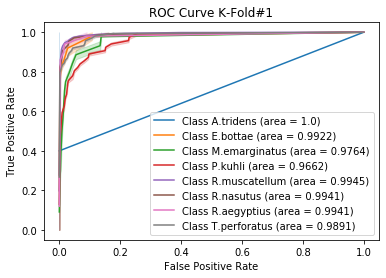

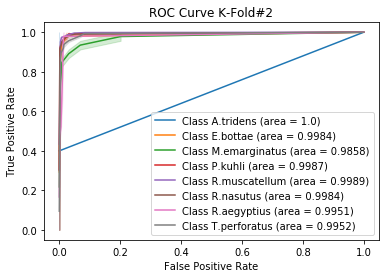

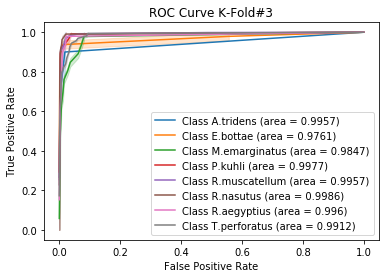

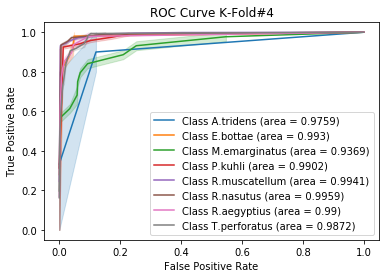

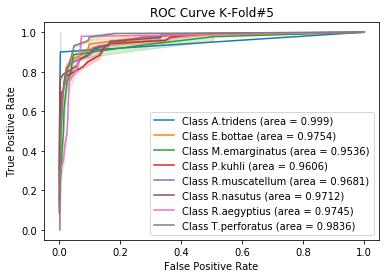

In [54]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

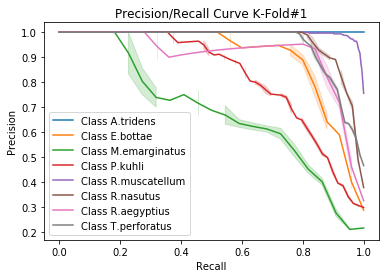

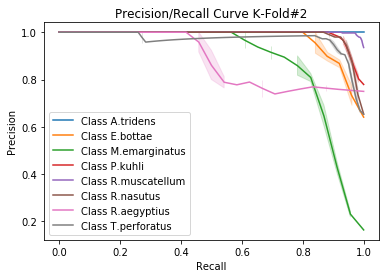

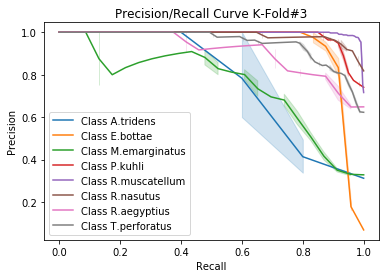

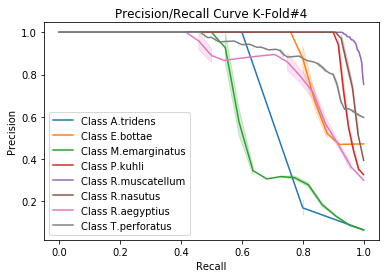

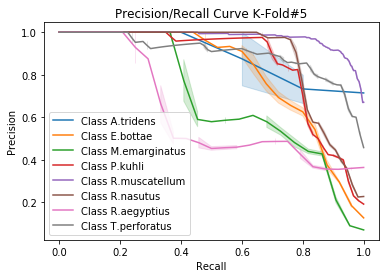

In [55]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  4   0   0   0   1   0   0   0]
 [  0  22   0   0   3   0   0   0]
 [  0   0  20   0   1   0   1   0]
 [  0   0  20  35   4   0   0   0]
 [  0   0   3   0 330   0   0   0]
 [  0   9   0   7   0  38   0   0]
 [  0   1   4   0   8   0  12   0]
 [  0   0  12   1  32   0   0  36]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  20   0   0   1   3   1   0]
 [  0   0  20   0   0   0   1   2]
 [  0   0   3  57   0   0   0   0]
 [  0   0   1   3 317   0   2  10]
 [  0   0   1   2   0  50   0   0]
 [  1   0   2   0   0   0  18   3]
 [  0   0   2   0   0   0   2  77]]


Confusion Matrix K-Fold #3

[[  3   0   1   0   0   0   0   1]
 [  0  23   0   0   1   0   0   0]
 [  0   0  18   0   1   0   0   4]
 [  0   0   2  52   0   1   0   5]
 [  0   1   1   0 329   0   0   2]
 [  0   8   1   1   0  44   0   0]
 [  0   0   9   0   0   0  15   0]
 [  0   0   1   0  11   0   1  68]]


Confusion Matrix K-Fold #4

[[  4   0   0   0   1   0   0   0]
 [  

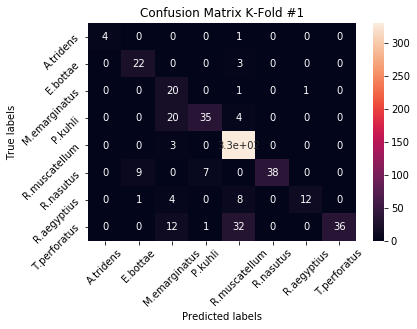

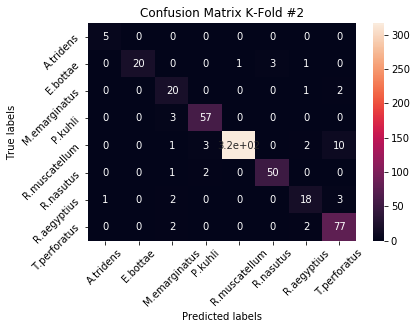

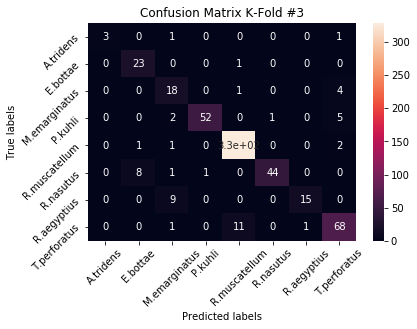

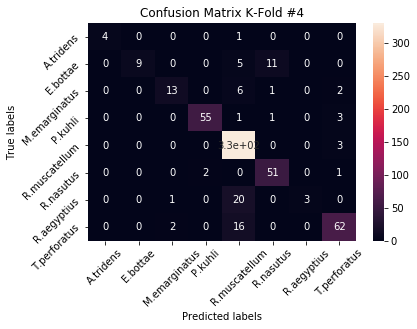

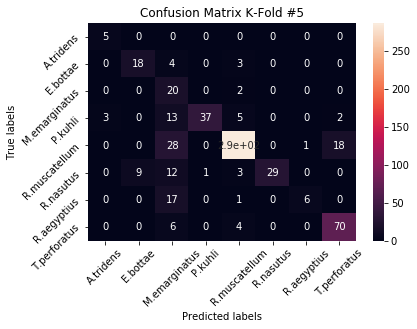

In [56]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    1    0    2    0    0    1]
 [   0   92    4    0   13   14    1    0]
 [   0    0   91    0   10    1    2    8]
 [   3    0   38  236   10    2    0   10]
 [   0    1   33    3 1592    0    3   33]
 [   0   26   14   13    3  212    0    1]
 [   1    1   33    0   29    0   54    3]
 [   0    0   23    1   63    0    3  313]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  18   0   0   2   2   0   0]
 [  0   0  18   0   2   0   0   1]
 [  0   0   7  47   2   0   0   2]
 [  0   0   6   0 318   0   0   6]
 [  0   5   2   2   0  42   0   0]
 [  0   0   6   0   5   0  10   0]
 [  0   0   4   0  12   0   0  62]]


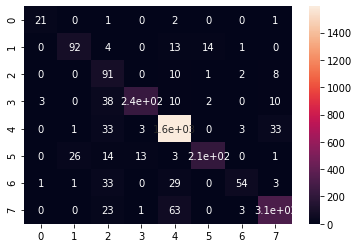

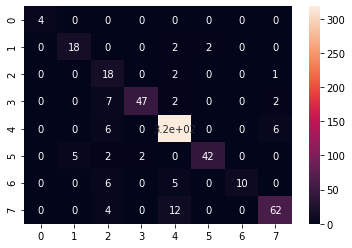

In [57]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.04 0.   0.08 0.   0.   0.04]
 [0.   0.74 0.03 0.   0.1  0.11 0.01 0.  ]
 [0.   0.   0.81 0.   0.09 0.01 0.02 0.07]
 [0.01 0.   0.13 0.79 0.03 0.01 0.   0.03]
 [0.   0.   0.02 0.   0.96 0.   0.   0.02]
 [0.   0.1  0.05 0.05 0.01 0.79 0.   0.  ]
 [0.01 0.01 0.27 0.   0.24 0.   0.45 0.02]
 [0.   0.   0.06 0.   0.16 0.   0.01 0.78]]


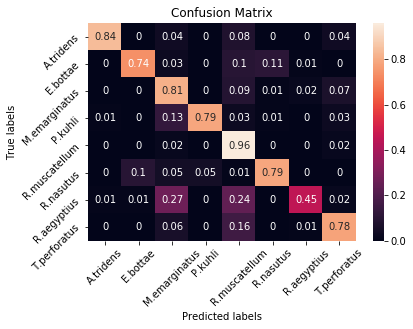

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [ ]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model